In [ ]:
import numpy as np
import tensorflow as tf
import keras as keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


# os.chdir("C:/Users/Dawit/Desktop/Keras/")
# os.chdir('C:/Users/Dawit/Desktop/Keras/dogvscat/')
# os.mkdir("two")
# print(str(os.getcwd()))

### Step-1 Date Prepation

In [ ]:
#organize the data into train,valid and test
os.chdir('C:/Users/Dawit/Desktop/Keras/dogvscat/')
# if os.path.isdir('one') is True: # make it false to repopulate again 
#     os.makedirs('train/dog')
#     os.makedirs('train/cat')
#     os.makedirs('valid/dog')
#     os.makedirs('valid/cat')
#     os.makedirs('test/dog')
#     os.makedirs('test/cat')

# for c in random.sample(glob.glob('cat*'),500):
#     shutil.move(c,'train/cat')
# for c in random.sample(glob.glob('dog*'),500):
#     shutil.move(c,'train/dog')

# for c in random.sample(glob.glob('cat*'),100):
#     shutil.move(c,'valid/cat')
# for c in random.sample(glob.glob('dog*'),100):
#     shutil.move(c,'valid/dog')

# for c in random.sample(glob.glob('cat*'),100):
#     shutil.move(c,'test/cat')
# for c in random.sample(glob.glob('dog*'),100):
#    shutil.move(c,'test/dog')

## processing the data and put the image in keras generator
os.chdir('C:/Users/Dawit/Desktop/Keras/') # change the dir to access the data
train_path = 'dogvscat/train'
valid_path = 'dogvscat/valid'
test_path = 'dogvscat/test'

train_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory=train_path, target_size=(224,224),classes=['cat','dog'],batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory=valid_path, target_size=(224,224),classes=['cat','dog'],batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory=test_path, target_size=(224,224),classes=['cat','dog'],batch_size=10,shuffle=False)


assert train_batches.n == 1000
assert test_batches.n == 200
assert valid_batches.n == 200
assert train_batches.num_classes == test_batches.num_classes == valid_batches.num_classes == 2
# print(train_batches)

In [ ]:
# grab single batch of images in the corresponding label
# since the batch size is 10, it will contain 10 images with their corresponding labels
imgs, labels = next(train_batches)

# plot the images we obained above
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


plotImages(imgs)
print(labels)


#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------

## The images are changed and a little bit distorted due to the function we call from VGG16 preprocessing
## VGG16 is a pretrained image classification model 

#  ARCHITECTURE
# The only pre-processing we do is substracting the mean RGB value computed on the 
# training set from each pixex.
##### => => => -> -> -> => => =>  THAT IS WHAT THE COLOR DISTORTION IS ALL ABOUT


#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------

### Step-2 Build CNN and trait it on keras

In [ ]:
# built a model
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu',padding='same', input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax'),
])

### show the summary of our model
# model.summary()

### prepare the model for training by compiling it
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

### train the model with model.fit()
model.fit(x=train_batches,validation_data=valid_batches,epochs=10,verbose=2)


# __Save and load the model__

In [ ]:
import os
os.chdir('C:/Users/Dawit/Desktop/Keras/')
model.save('one.h5')
# print(os.getcwd())

# __Loading... Finished__

## Step-3 Predict
### hwo to use our CNN for inference to predict on image data


In [ ]:
### get a batch of test data from test_batches
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

### display the labels of test samples since we don't shuffle, it always
### have the same result and helps to analyse the efficiency of our model in confusin matrix
# test_batches.classes   

#predict 
predictions = model.predict( x=test_batches, verbose=0)
np.round(predictions)

### Step-4 Lets use Confuse matrix to visualize the result of our model


In [ ]:
cm = confusion_matrix(y_true=test_batches.classes,
                      y_pred=np.argmax(predictions, axis=-1))

# plot the result of confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='confusion_matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion matrix ')
    else:
        print('Confusion Matrix, without Normalization')

    print(cm)
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


test_batches.class_indices
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes = cm_plot_labels, title='Confusion Matrix' )

## ___Step-5 Built Fine-tunned VGG16 model___


In [ ]:
#download VGG16, for the first time it need internet connection
vgg16_model = keras.applications.vgg16.VGG16()

In [ ]:
vgg16_model.summary()
#---------------------------------------------------------------
#---------------------------------------------------------------
#---------------------------------------------------------------

# as you see from the summary predition (Dense) => 1000 
# since vgg16 was originally designed to classify 1000 different classes
# Our objective is simply change this 1000, to predict only 2 classes
# just cat and dog
#
#---------------------------------------------------------------
#---------------------------------------------------------------
#---------------------------------------------------------------
#---------------------------------------------------------------

# __VVG16 Sequential Model__

### __VGG16 is a bit more complicated and sophesticated than sequenctial model.__
###  __So we need to convert it to sequential model__

In [ ]:
### the model is this
### NOTE => in here layers[:-1], the last part of VGG16 model which is prediction is not included
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)


### model summary
model.summary()


In [ ]:
type(vgg16_model)

#### Here, we are going to iterate all layers of our new sequential model. And setting each layers to be __non-trainable__
#### By doing this, we can __freeze the trainable prameters__ or __wieghts and biases__ all the layers in the model so that they are not going to be retrained whenever we go through training process

##### __You can check this by model.summary() and the last one tells non-trainable parametes numbers. If you printout VGG16 model is non-trainable prameters in 0, but know the only trainable prameters are out last output layer__

In [ ]:
## make each layer of model to be non-trainable 
## OR FREEZE trainable parameters, weiths and biases
for layer in model.layers:
    layer.trainable= False

### __adding our own output layer which has only 2 output classes__

In [ ]:
model.add(Dense(units=2,activation='softmax'))
# model.summary()

#### __It summary is this__

In [ ]:
model.summary()

##### __Since we make all the privious layers non-trainable, the last output layer we added is the only trainable layer in our model. So we only need to train this last layer to classify two output classes__
### ___how to train our fine-tunned VGG16 model in ours own dataset ?___
### ___Lets see how it is done___

In [ ]:
## compile it, to get it ready for training using Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

## train the model with model.fit()
model.fit(x=train_batches,validation_data=valid_batches,epochs=5,verbose=2)

# __Save VGG16 fine-tunned model__

In [ ]:
os.chdir('C:/Users/Dawit/Desktop/Keras/')
model.save('fine-tune.h5')

## __Predict__ 
#### ___Use ours Fine-tuneed VGG16 model for inference to predict on images in our test___

In [ ]:
## use model.preditions
predictions = model.predict(x=test_batches,verbose=0)

In [ ]:
## since we didn't suffle the test set image data set, we want to access the classes here in unshuffled order so that we can pass it the corresponding values of unshuffled orders
test_batches.classes

In [33]:

cm = confusion_matrix(y_true=test_batches.classes,y_pred=np.argmax(predictions,axis=-1))
test_batches.class_indices

{'cat': 0, 'dog': 1}

In [35]:
# plot the result of confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='confusion_matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion matrix ')
    else:
        print('Confusion Matrix, without Normalization')

    print(cm)
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Confusion Matrix, without Normalization
[[96  4]
 [ 3 97]]


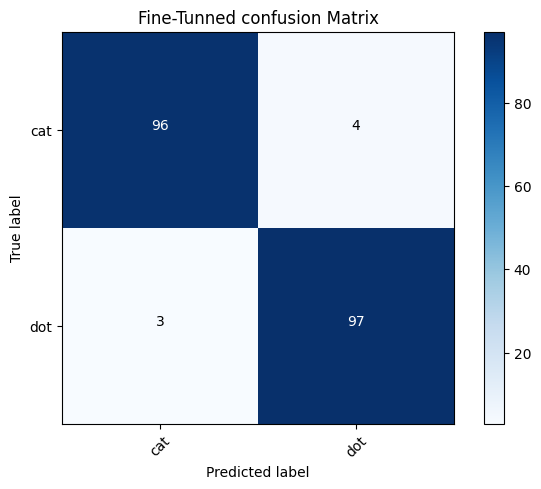

In [36]:
cm_plot_labels=['cat','dot']

plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Fine-Tunned confusion Matrix')

### 